# __2024 ASA DataFest at UCLA__

# Challenge Description
The CourseKata project aims to **improve the learning experience of students** studying statistics and data science by analyzing their interaction data with the online interactive textbooks. This dataset contains interactions from 1625 students across 48 college-level statistics and data science courses in the U.S. (2023). Your challenge is to examine this data to generate actionable insights and provide suggestions for improving the student learning experience.

---------------------

# __First Suggestion: Alert system__
* To enhance the learning experience, **providing the right help at the right time is crucial**. With this in mind, I propose the idea of an **alert system that identifies students who are likely to struggle** and could possibly notifies teachers accordingly.

* The goal of this suggestion is to **develop a predictive model** that can estimate a student’s future performance in end-of-chapter (EOC) assessments based on their previous performance. Specifically, we aim to **predict scores for future chapters by analyzing a student's scores up until that point** using the 'checkpoint_eoc.csv' file.

* The dataset contains the following columns:

    **student_id**: A unique identifier for each student.

    **book**: The name of the book used in the course (in this case, "College / Advanced Statistics and Data Science (ABCD)").

    **chapter_number**: The chapter number corresponding to the EOC question.

    **EOC**: The score the student achieved on the EOC for that chapter.

    This structure allows us to leverage a student's past performance in earlier chapters (e.g., Chapter 1, 2, 3) to predict how they will perform in subsequent chapters.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

# 1. Data preparation

## 1-1. Load the data

In [25]:
# load the data
full_eoc = pd.read_csv("./Data/Full Data/checkpoints_eoc.csv")

# Select one book
full_eoc_abcd = full_eoc[full_eoc['book'] == "College / Advanced Statistics and Data Science (ABCD)"]

# Select the column needed(student_id, EOC(score), chapter_number)
full_eoc_abcd = full_eoc_abcd[["student_id", "EOC", "chapter_number"]]

## 1-2. Clean the Data

In [47]:
# Delete students that have duplicate chapters
duplicates = full_eoc_abcd.groupby(['student_id', 'chapter_number']).size().reset_index(name='count')
duplicate_students = duplicates[duplicates['count'] > 1]['student_id'].unique()
full_eoc_abcd = full_eoc_abcd[~full_eoc_abcd['student_id'].isin(duplicate_students)]

unique_students = full_eoc_abcd['student_id'].unique()
train_students, test_students = train_test_split(unique_students, test_size=0.2, random_state=42)

# Split the data based on the student_id groups
train_data = full_eoc_abcd[full_eoc_abcd['student_id'].isin(train_students)]
test_data = full_eoc_abcd[full_eoc_abcd['student_id'].isin(test_students)]

print(train_students[0:5])
print(train_data[0:20])

['d00636be-958e-4009-b4d8-372ccb6c4de0'
 'a80098b9-af6d-4bd4-81eb-8e5376b0ac7b'
 '70340dca-cd35-4cd7-a243-7b487fe25507'
 '44cb0e81-83b7-4fb1-91b1-7ec47b296af2'
 '9bec904c-7776-4560-b600-45fbcebe7ad9']
                               student_id       EOC  chapter_number
44   016e2fcf-0cc2-42ad-844d-e1057b5081cc  0.854545               1
45   016e2fcf-0cc2-42ad-844d-e1057b5081cc  0.772727               2
154  0346e6a3-d123-4e14-a86d-fbcefeb6eb86  0.902439               1
155  0346e6a3-d123-4e14-a86d-fbcefeb6eb86  0.853659               2
156  0346e6a3-d123-4e14-a86d-fbcefeb6eb86  0.776119               3
157  0346e6a3-d123-4e14-a86d-fbcefeb6eb86  0.787500               4
158  0346e6a3-d123-4e14-a86d-fbcefeb6eb86  0.666667               6
159  0346e6a3-d123-4e14-a86d-fbcefeb6eb86  0.500000               7
160  0346e6a3-d123-4e14-a86d-fbcefeb6eb86  0.720000               8
161  0346e6a3-d123-4e14-a86d-fbcefeb6eb86  0.676471               9
162  0346e6a3-d123-4e14-a86d-fbcefeb6eb86  0.698413

### 1-2-1. Check the missing data
After imputation, the goal is to have a complete dataset with scores for all chapters for each student.

In [87]:
# Expected total number of rows
num_chapters = max(train_data['chapter_number'])
num_students = train_data['student_id'].nunique()
total_num = num_chapters*num_students

print(f"Expected to be {total_num} rows.")

Expected to be 6624 rows.


In [84]:
# Original Data
na_counts = train_data['EOC'].isna().value_counts().reset_index()
na_counts.rename(columns={'EOC': 'Is it NA'}).sort_values(by='count')
not_na = na_counts['count'][0]

print(na_counts)

     EOC  count
0  False   4977
1   True     18


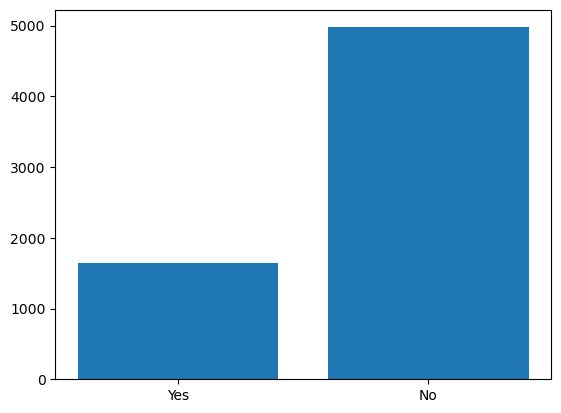

Percentage of the NA values: 24.86%


In [95]:
plt.bar(['Yes', 'No'], [total_num - not_na, not_na])
plt.show()

frac = ((total_num - not_na) / total_num)*100
print(f"Percentage of the NA values: {frac:.2f}%")

### 1-2-2. Impute missing values

In [5]:
def fill_missing_chapters(group, chap_num):
    '''
    Making the student's score complete(n number of chapters in this book)
    Compute the NAs of scores if applicable
    '''
    # Set the chapter_number as an index
    group.set_index('chapter_number', inplace = True)
    # Change the index from 1 to the number of chapter -> value NA if that index doesn't exist
    group = group.reindex(range(1, chap_num+1))
    # Impute NA with mean
    group['EOC'] = group['EOC'].fillna(group['EOC'].mean())
    return group


# Find the maximum number of chapter(varied between books)
chap_num = max(full_eoc_abcd['chapter_number'])

# Set the student_id as an index
train_data.set_index('student_id', inplace=True)

# Groupby with student_id and apply fil_missing_chapters function
train_data_grouped = train_data.groupby('student_id').apply(fill_missing_chapters, chap_num)

# Reset the index(Make it cleaner)
train_data_grouped.reset_index(inplace=True)

# Set the student_id as an index
test_data.set_index('student_id', inplace=True)

# Groupby with student_id and apply fil_missing_chapters function
test_data_grouped = test_data.groupby('student_id').apply(fill_missing_chapters, chap_num)

# Reset the index(Make it cleaner)
test_data_grouped.reset_index(inplace=True)

In [6]:
# Save file
full_eoc_abcd.to_csv('cleaned_full_eoc.csv')

In [17]:
train_data_grouped.head()

,student_id,chapter_number,EOC
0,016e2fcf-0cc2-42ad-844d-e1057b5081cc,1,0.854545
1,016e2fcf-0cc2-42ad-844d-e1057b5081cc,2,0.772727
2,016e2fcf-0cc2-42ad-844d-e1057b5081cc,3,0.813636
3,016e2fcf-0cc2-42ad-844d-e1057b5081cc,4,0.813636
4,016e2fcf-0cc2-42ad-844d-e1057b5081cc,5,0.813636


In [18]:
test_data_grouped.head()

,student_id,chapter_number,EOC
0,0096491a-77bf-4e79-b906-fc7a8e5e57a6,1,0.636364
1,0096491a-77bf-4e79-b906-fc7a8e5e57a6,2,0.580952
2,0096491a-77bf-4e79-b906-fc7a8e5e57a6,3,0.765217
3,0096491a-77bf-4e79-b906-fc7a8e5e57a6,4,0.583333
4,0096491a-77bf-4e79-b906-fc7a8e5e57a6,5,0.426667


In [9]:
# Each component consist of each student
train_EOC = np.array(train_data_grouped['EOC']).reshape(-1, chap_num)
test_EOC = np.array(test_data_grouped['EOC']).reshape(-1, chap_num)
train_EOC.shape, test_EOC.shape

((414, 16), (104, 16))

# 2. Exploratory Data Analysis (EDA)

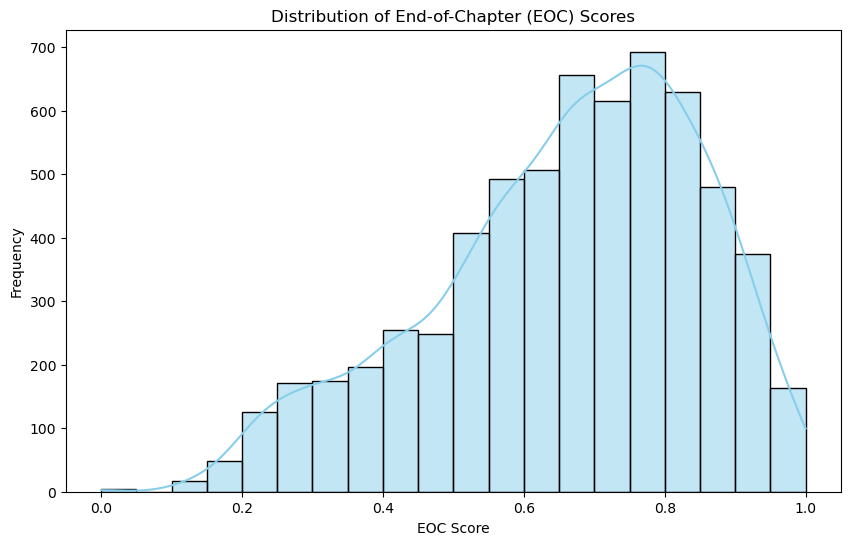

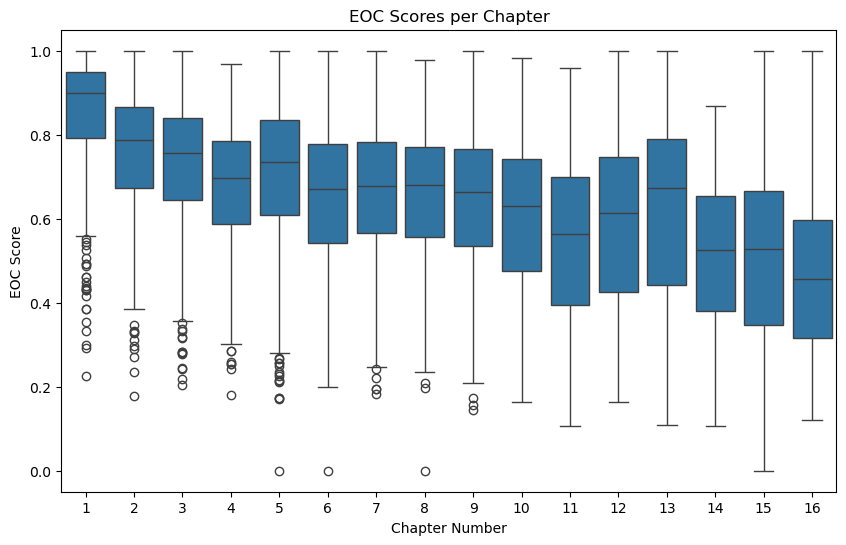

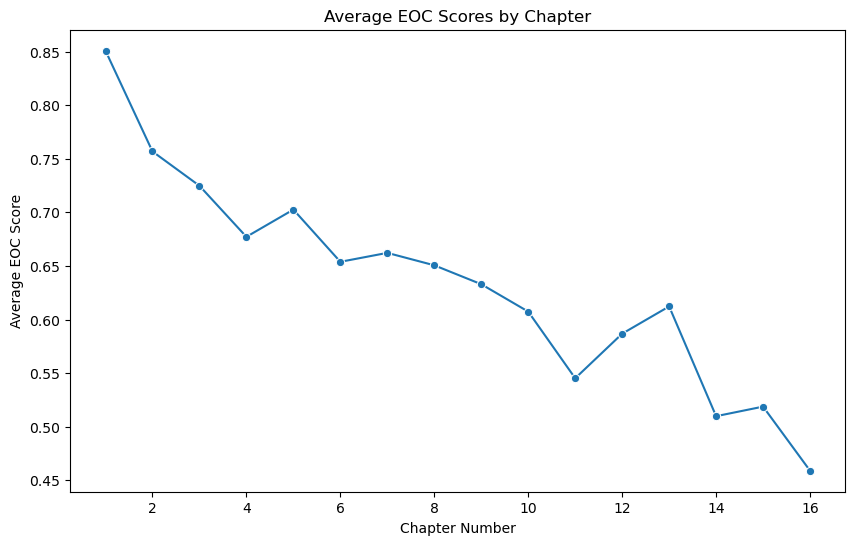

In [97]:
# Plot distribution of EOC scores for the whole dataset
plt.figure(figsize=(10, 6))
sns.histplot(full_eoc_abcd['EOC'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of End-of-Chapter (EOC) Scores')
plt.xlabel('EOC Score')
plt.ylabel('Frequency')
plt.show()

# Explore the correlation between chapter numbers and EOC scores
plt.figure(figsize=(10, 6))
sns.boxplot(x='chapter_number', y='EOC', data=full_eoc_abcd)
plt.title('EOC Scores per Chapter')
plt.xlabel('Chapter Number')
plt.ylabel('EOC Score')
plt.show()

# Identify if there are any patterns by chapter
chapter_mean_scores = full_eoc_abcd.groupby('chapter_number')['EOC'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='chapter_number', y='EOC', data=chapter_mean_scores, marker='o')
plt.title('Average EOC Scores by Chapter')
plt.xlabel('Chapter Number')
plt.ylabel('Average EOC Score')
plt.show()

# 3. Modeling

## Train the Random Forest Model

In [10]:
imputer = SimpleImputer(strategy='mean')

# Impute missing values in train_EOC
train_EOC_imputed = imputer.fit_transform(train_EOC)

models = {}

for seq_len in range(1, chap_num):
    # Create training data which have 1 score, 2 scores, ... chap_num of scores
    X_train = train_EOC_imputed[:, :seq_len]
    # The next data point that we want to predict
    y_train = train_EOC_imputed[:, seq_len]

    # Check if y_train contains NaN values and remove corresponding rows
    mask = ~np.isnan(y_train)
    X_train, y_train = X_train[mask], y_train[mask]

    # Model initialization and training
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    
    # Save the model
    models[seq_len] = model

# 4. Model Assessment

In [13]:
# Convert scores to class labels based on the defined tiers
def score_to_class(score, tier1, tier2):
    if score >= tier2:
        return 0  # Above tier2, set as class 0
    elif score >= tier1:
        return 1  # Between tier1 and tier2, set as class 1
    else:
        return 2  # Below tier1, set as class 2


# Empty dictionary to save the accuracies of models
accuracies = {}
# Set the cutoff
tier1 = 0.2
tier2 = 0.3


# Loop over sequence lengths
for seq_len in range(4, chap_num):
    model = models.get(seq_len)

    # Predict for the test set
    X_test = test_EOC[:, :seq_len]
    y_test = test_EOC[:, seq_len]
    y_pred = model.predict(X_test)

    # Convert the predictions and actual values to classes
    y_test_classes = np.array([score_to_class(y, tier1, tier2) for y in y_test])
    y_pred_classes = np.array([score_to_class(y, tier1, tier2) for y in y_pred])

    # Calculate and store the accuracy for this sequence length
    accuracies[seq_len] = accuracy_score(y_test_classes, y_pred_classes)

# Output the accuracy for each sequence length
for seq_len, accuracy in accuracies.items():
    print(f"Accuracy for sequence length {seq_len}: {accuracy:.2f}")

Accuracy for sequence length 4: 0.94
Accuracy for sequence length 5: 0.94
Accuracy for sequence length 6: 0.94
Accuracy for sequence length 7: 0.95
Accuracy for sequence length 8: 0.92
Accuracy for sequence length 9: 0.92
Accuracy for sequence length 10: 0.88
Accuracy for sequence length 11: 0.93
Accuracy for sequence length 12: 0.89
Accuracy for sequence length 13: 0.91
Accuracy for sequence length 14: 0.91
Accuracy for sequence length 15: 0.90


# 5. Feature Importance Visualization

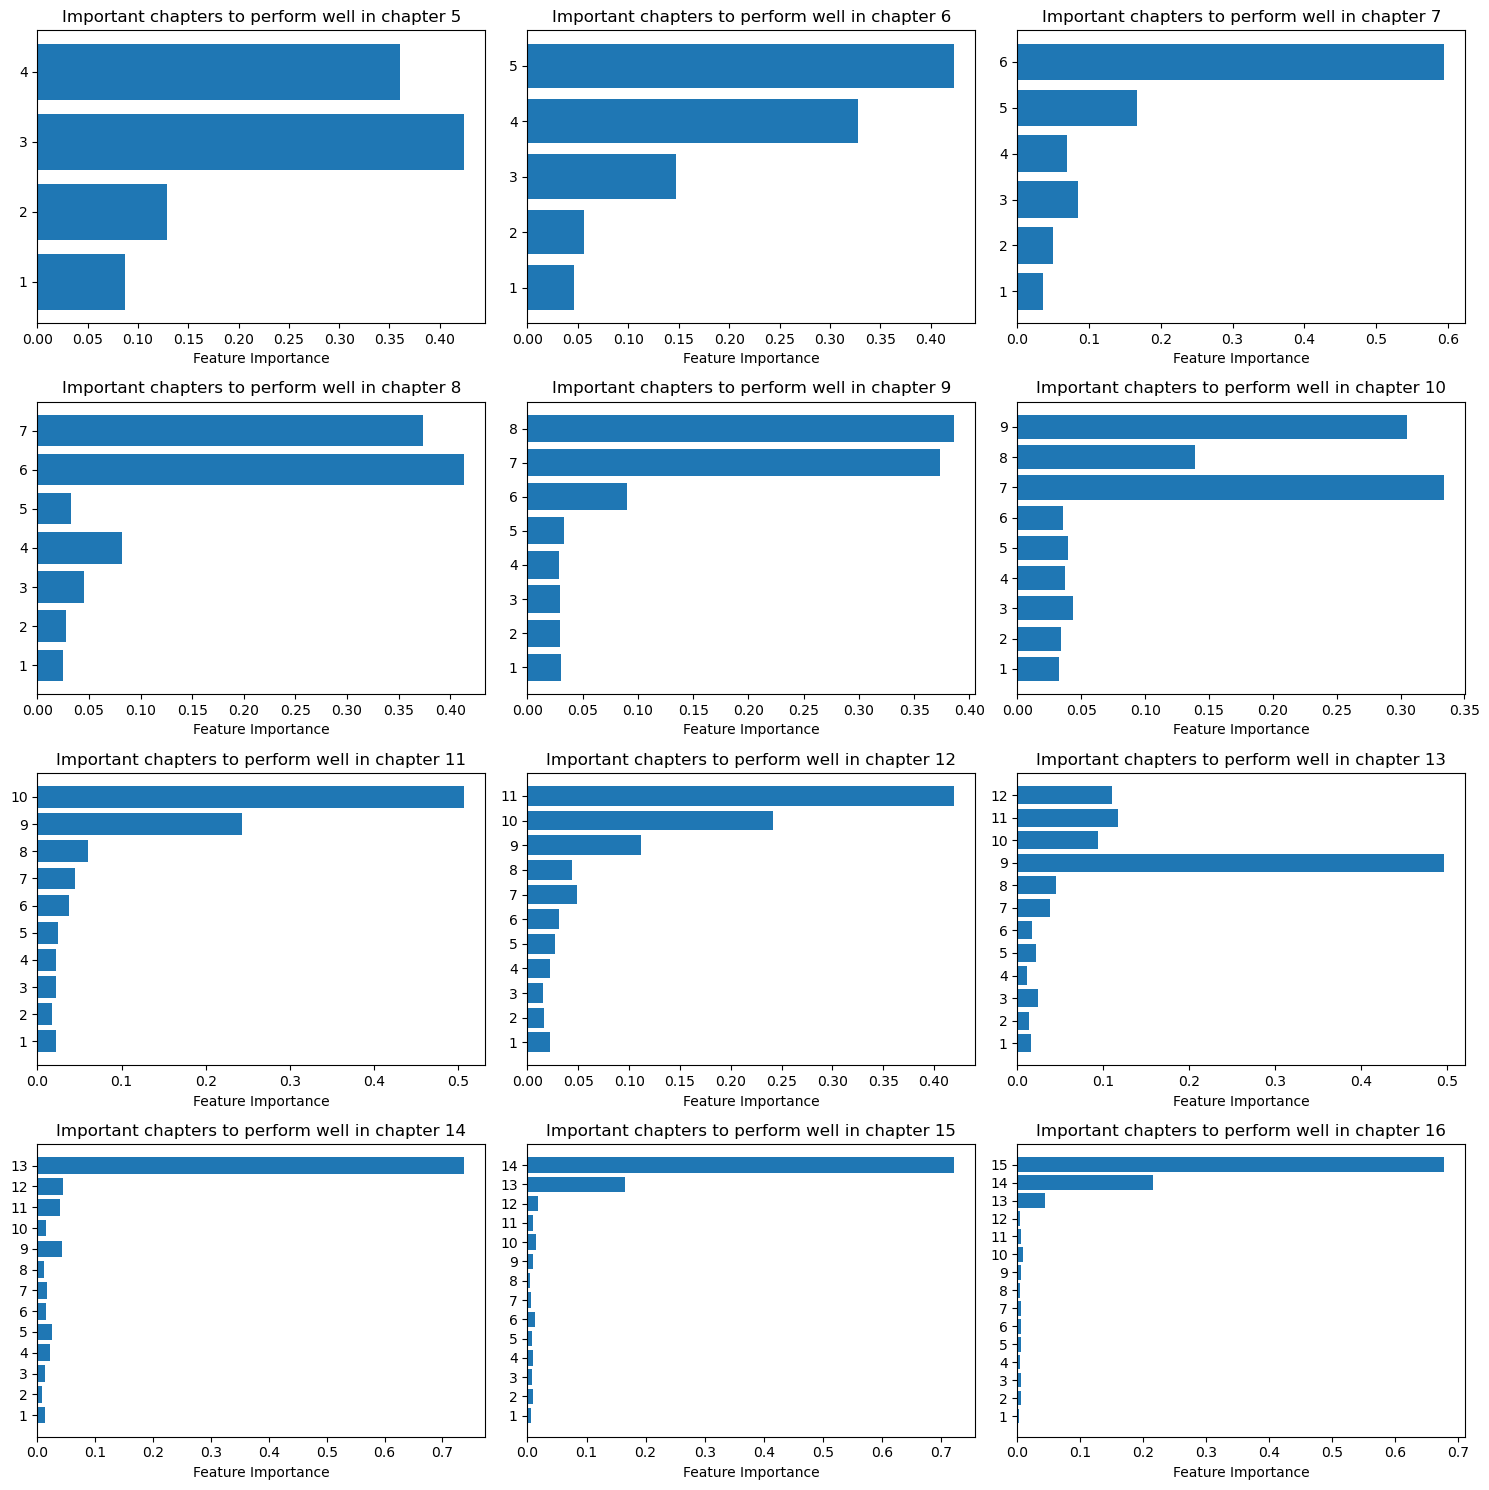

In [14]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))  # 4x3 subplots
axes = axes.ravel()

for i, seq_len in enumerate(range(4, chap_num)):
    model = models[seq_len]
    importances = model.feature_importances_
    
    axes[i].set_title(f'Important chapters to perform well in chapter {seq_len+1}')
    axes[i].barh(range(seq_len), importances, align='center')
    axes[i].set_yticks(range(seq_len))
    axes[i].set_yticklabels(np.arange(1, seq_len + 1))
    axes[i].set_xlabel('Feature Importance')

plt.tight_layout()
plt.show()

# 6. Visualization of Predictions for a Single Student

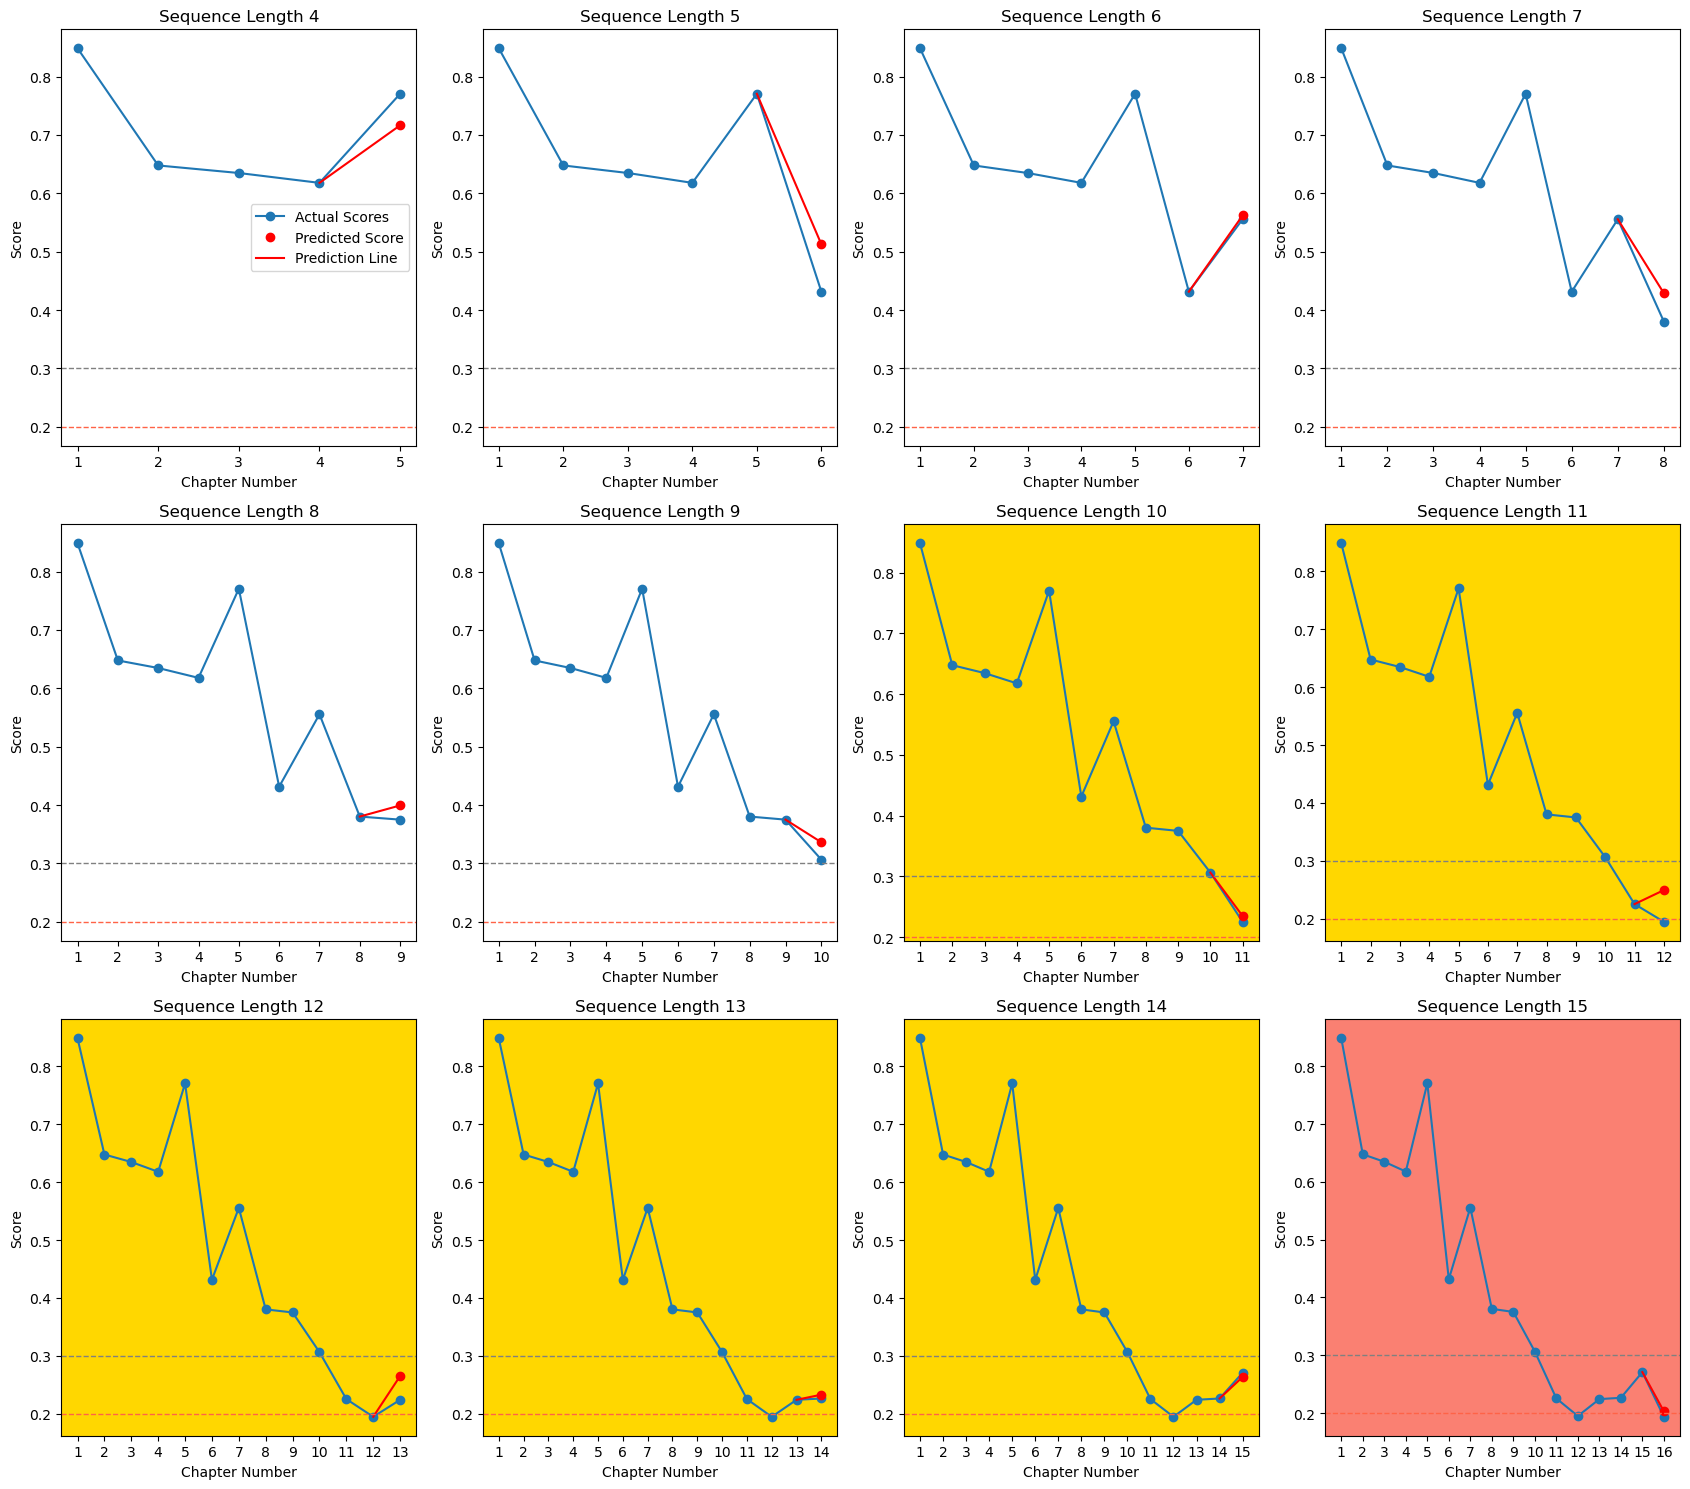

In [16]:
def new(id):
    # New data
    stu = full_eoc_abcd[full_eoc_abcd['student_id'] == id]
    stu.set_index('student_id', inplace=True)
    # Groupby with student_id and apply fil_missing_chapters function
    stu = stu.groupby('student_id').apply(fill_missing_chapters, chap_num)
    # Reset the index(Make it cleaner)
    stu.reset_index(inplace=True)
    return stu

# Choose one student
stu = new('5f7aee38-fac6-4ddb-9c0f-38a5e2706d66')

# Visualize
fig, axes = plt.subplots(3, 4, figsize=(17, 15))  # 4x3 subplots
axes = axes.ravel()

# Create new data
stu = np.array(stu["EOC"])

for i, seq_len in enumerate(range(4, chap_num)):
    model = models[seq_len]  # Adjust the index if necessary, based on your models list

    # Create new data of length seq_len
    scores_to_predict = stu[:seq_len].reshape(1, -1)
    predicted_score = model.predict(scores_to_predict).flatten()  # Flatten to ensure it's a 1D array

    scores = stu[:seq_len + 1]  # All actual scores up to seq_len

    # Draw the line graph
    axes[i].plot(range(1, seq_len + 2), scores, marker='o', label='Actual Scores')
    axes[i].set_title(f'Sequence Length {seq_len}')
    axes[i].set_xlabel('Chapter Number')
    axes[i].set_ylabel('Score')
    axes[i].set_xticks(np.array(range(1, seq_len + 2)))

    # Add the predicted value as a red dot
    if predicted_score.size > 0:  # Check if predicted_score is not empty
        axes[i].plot(seq_len + 1, predicted_score[0], 'ro', label='Predicted Score')  # Plot only the first element

        # Connect the last real score to the predicted score with a red line
        if seq_len > 0:
            last_real_value = scores[-2]  # Last real score
            axes[i].plot([seq_len, seq_len + 1], [last_real_value, predicted_score[0]], 'r-', label='Prediction Line')
            
        # Check predicted_score and set background color
        if np.round(predicted_score[0], 2) <= tier1:
            axes[i].set_facecolor('salmon')  # If the predicted score is below 0.2, set background to red
        elif np.round(predicted_score[0], 2) <= tier2:
            axes[i].set_facecolor('gold')  # If the predicted score is below 0.3 but above 0.2, set background to yellow
            
            
    # Add a horizontal dotted line at y=0.5
    axes[i].axhline(y=tier1, color='tomato', linestyle='--', linewidth=1)
    axes[i].axhline(y=tier2, color='gray', linestyle='--', linewidth=1)

    # Add legend only on the first subplot
    if i == 0:
        axes[i].legend()

plt.tight_layout()
plt.show()